# Overview

In this notebook we explore the gaussian process.

As the name suggests the gaussian process is a stochastic process characterized by the gaussian distribution. For more information consider the materials provided in the [Stocastics notebook](Stochastics.ipynb) and the notebook for the [Normal distribution](../Probability/Normal%20Distribution/Normal%20Distribution.ipynb).

# Prerequisites
- [Stocastics](Stochastics.ipynb)
- [Normal Distribution](../Probability/Normal%20Distribution/Normal%20Distribution.ipynb)

# 1. Gaussian Process Regression

## 1.1. Overview

Gussian process regression is a technique which calibrates a [gussian process](../Stochastics/Stochastics.ipynb#Gaussian-Process) so that it models a set of observations. The intent is that once calibrated appropriately, the model can be used to make predictions. This technique goes by a few names including krigging and Wiener–Kolmogorov prediction.

Unlike many popular supervised machine learning algorithms that learn exact values for every parameter in a function, the Bayesian approach infers a probability distribution over all possible values.

Additionally, it is non-parametric and based on bayesian probability/inference.

The model is flexible as we do not neet to specify the underlying process and can model almost any function.

## 1.2. History and Origin
The theoretical basis for the method was developed by the French mathematician Georges Matheron in 1960
His work was based on the Master's thesis of Danie G. Krige who sought to estimate the most likely distribution of gold based on samples from a few boreholes. The term kriging was coined some time after in honor of Krige.
https://en.wikipedia.org/wiki/Kriging

## 1.3. Technique Overview

As the name suggests which is an analog of simple linear regression. Instead of fitting a line to our data (and thus predicting a specific value for a specific point) we are fitting a gaussian process to our data (and thus predicting a probability distribution for a specific point).

<center><img src='images/gaussian_process_distribution_prediction.png' width='400px'></center>

Note: The Image above was taken from this [lecture](https://www.youtube.com/watch?v=exqpaqaPG2M). A similarely helpful lecture can be found [here](https://www.youtube.com/watch?v=4vGiHC35j9s).

It shows, for each value $x_i \in x$ we will construct a probability dsitrubtion $\mathcal{N}_i$ to explain the possible values that $y_i$ may take on. 

$$ \mathcal{G}_i \sim \mathcal{N}_i $$

Consequently, for each point, we  get a prediction $\mu_i = \hat f_i$ but we also get a measure of uncertainy of the prediction in the form of $\sigma_i$.

Additionally we state that there is some relationships between these distributions and thus the points. This relationship over some index is what makes this a process. And because of the specific distribution, the process can be modled by the multivariate normal distribution.

An thus, the technique starts by asserting that a function $f(x)$ or variable $y$ can be modeled by a gaussian process:

$$ y := f(x) \approx \mathcal{G}_i$$

As we are modeling a non-trivial trend, the gaussian distribution parameters are expected to change over time which allows our process to change and exhibit trends.

$$ \mathcal{G}_i \sim \mathcal{N}(\mu_i, \Sigma_i)$$

We can think of a random process as a joint event such that the occurance of a process implies the occurance of a set of observations. As such we can model the probability of the process yielding the observed values as a joint probability. Because the process is gaussian, and thus the individual distributions are gaussian, we can actually derive concrete statements and formulas for this probability in the form of the multivariate gaussian distribution.

And this is where we start to see the opportunity to introduce bayesian inference into regression:

If we focus on a single prediction, we can effectively split our index into two segments. In segment one we have all the observed data points and in segment two we have all the data points we are trying to predict. Thus our segmented function can be represented as:

$$\begin{bmatrix}
f_1 \\ f_2
\end{bmatrix}
\sim
\mathcal{N}
\begin{pmatrix}
    \begin{bmatrix}
    \mu_1 \\
    \mu_2
    \end{bmatrix},
    \begin{bmatrix}
    \Sigma_{11} & \Sigma_{12} \\
    \Sigma_{21} & \Sigma_{22}
    \end{bmatrix}
\end{pmatrix}
$$

As we have formulated a joint probability distribution, we are stating that some relationship exists between these points. In fact, if we apply the theory of conditional probability, bayes theorem, and do the arduous matrix algebra we can derive a conditional probability distribution which stated the probabilities associated with $f_2$ given the occurance of $f_1$.

$$ f_2 | f_1 \sim \mathcal{N}(\mu_{f_2 | f_1}, \Sigma_{f_2 | f_1}) $$

With distribution moments:

$$ \mu_{f_2 | f_1} =  \mu_1 + \Sigma_{11}^{-1}\Sigma_{21}(x_2 - \mu_2)$$

$$ \Sigma_{f_2 | f_1} = S_{\Sigma/\Sigma_{11}} = \Sigma_{22} - \Sigma_{21}^{-1}\Sigma_{11}^{-1}\Sigma_{12}$$

**Note**: at this point we begin to leave the realm of exact science/mathematical riggor and we begin to enter the world of approximation. This was not called out explicitly in the materials I reviewed it and was extremely confusing for me as I tried to rigorously prove things which do not require riggor. We will see that we are going to make some statements and assumptions which are more artistic than scientific. But these assumptions are the heart of our model. They introduce an imperfect method to guess what the value of our prediction could/should be.

There are a few problems with the formulas above preventing them from being useful (which again is surprising as no one seems to acknowledge directly):
1. $f_2$ is unknown which implies that $\mu_2$, $\Sigma_{22}$, and $\Sigma_{22}$ are also unknown. This means we cannot compute the conditional mean or conditional covariance.
2. The standard covariance formula $Cov(x,y) = \frac{(x-\mu_x)(y-\mu_y)}{n-1}$ is not guaranteed to produce a positive definite matrix. In fact, I tried multiple examples and failed to generate a positive definite covariance matrix. As such we cannot take the inverse and compute the conditional covariance.


As such, we will see a lot of texts employ the following workarounds:
1. We will assume a value for $\mu_2$. To do this, we can either assume it is stationary and has a constant predetermined mean or that it is not stationary and we will compute a mean based on historical data.

2. We will assume/assert that $f$ is a smooth function. The reason for this is to establish that the covariance of $x$ can be used to approximate the covariance of $y$ on a relative basis. The basic idea is that a change in $x$ will be proportional to a change in $y$. In other words, if a point $x_i$ is close to a point $x_j$ then we will assume that a point $f_i$ is close to a point $f_j$. With this assumption, the covariance of $x$ will help us approximate values of $f$.

3. We will use alternate measurements to represent covariance which produce positive definite matrices more reliably. These functions are commonly referred to as **kernel functions** and will be discussed in their own section.


With these assumptions we now have a working mathematical system which can model our data. We will see that this model is versitile as we can make predictions for values coresponding to a domain we have not yet explored and we will be able to interpolate values between points in the domain we have explored.

Again, the heart of this model is thus the **kernel function** as it is really the major component that is artistically being selected.

Some additional notes:

1. There is a bit of a caveat when calculating $\Sigma_{11}^{-1}$. Numpy does offer a library to calculate the inverse, but there is a faster technique available for doing the calculation. We can calculate the $\Sigma_{11}^{-1}\Sigma_{21}$ term by solving a system of equations. We create an identity $Σ_{11} x = Σ_{12}$  which can be manipulated to $x = Σ_{12}/Σ_{11}$ or equivalently $Σ_{12}Σ_{11}^{-1}$. We will see this used in the coding examples below.

2.  I had some confusion early on because I was thinking about things in terms of a classical autoregression model. Meaning that I was thinking about the values of the prediction being tied to the time index. I was thinking that the order of the observations impacts the prediction. In other words I was thinking that when we make a prediction it is based on the previously observed values and their order. This is not the case with gaussian processes. We will see that a prediction for the value of a given point is based on the "similarity" of neighboring points (this is determined by the kernel function and discussed later). This is why we can both predict and interpolate. We will see examples of this below.

3. I have seen some texts try to draw a literal connection between gaussian process regression and linear regression. The premis is that the conditional mean is being used to represent the value of our prediction. Looking at its mathematical structure: $ \mu_{f_2 | f_1} =  \mu_1 + \Sigma_{11}^{-1}\Sigma_{21}(x_2 - \mu_2)$ we see that it can be considered a linear equation. 

   It is here that the connection with a regression is made. Recall that the generalized linear regression formula is such that:
   
   $$ f(x) = mX + b $$

   Looking at our conditional mean $\mu_{f_2 | f_1}$ we see that the formula resembles a linear regression. If we let $m = \Sigma_{11}^{-1}\Sigma_{21}$, $X=(x_2 - \mu_2)$, and $b=\mu_1$ we match exactly.

   Recalling that our model $\hat f(x)$ is an approximation and is subject to error $\epsilon$ we have:

   $$ \hat f(x) = f(x) + \epsilon $$

   While $\Sigma_{f_2 | f_1}$ measures the relative uncertainty in the prediction.

4. We previously suggested that we let $X=(x_2 - \mu_2)$ in our linear regression equation. In doing so, we are applying a normalizing transformation to $x_2$ such that X will have a mean of $0$ rather than $mu_2$. From the properties of a normal distribution we also know that linear transformations applied to a normal random variable is also normal. thus $X \sim \mathcal{N}(0, \sigma^2)$. Another interesting property of normal random variables is that an arbitrary normal distirbution $X$ can be represented as a transformation applied to a standard normal distirbution $\mathcal{Z}\sim\mathcal{N}(0,1)$ such that: $X = \mu_X + \sigma_X Z$. If you are not familiar with this equation, it is a brownian motion.

## 1.4. Kernels and Kernel Functions
As mentioned earlier kernels are an important part of the gaussian process.

This is [not set in stone](https://stats.stackexchange.com/questions/228552/covariance-functions-or-kernels-what-exactly-are-they) but philosophically, a kernel function yeilds a descriptive statistic explaining the relationship between the input variables.

Kernels are the mechanism by which we make estimations and predictions. The kernel mathematically deduces an prediction for a value based on an observation and the assumption of a smooth process.

There are many alternate kernel functions a data scientist could select to model the observed data which will be discussed below.

**Note**: Confusingly, term kernel or kernel function comes up a lot in various mathematical diciplines and confusingly has a number of unrelated definitions. I talk about them in the notebook on [kernels](../Functions/Kernels.ipynb).


### 1.4.1. Choosing an alternate kernel

There are assumptions, pros, and cons baked into each kernel function.

A few examples can be found here:
- https://www.cs.princeton.edu/~bee/courses/scribe/lec_10_09_2013.pdf
- [The kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/)

TODO: Expand on graph showing impact of different kernels

<center><img src='images/kernels_affecting_gaussian_process.png'  width='800px' height='800px' ></center>

https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

## 1.5. Limitations

- Slow inference. Computing the covariance matrix’s inverse has a O(N3) time complexity, rendering exact inference too slow for more than a few thousand data points.
- Choosing a covariance kernel. There’s some arbitrariness when choosing a kernel. However, the kernel’s hyperparameters can be inferred by maximizing the marginal likelihood, and the whole process can be automated.
- Gaussian processes are in some sense idealizations. For the understanding of extreme phenomena exhibited by real physical systems, non-Gaussian processes might turn out more suitable. In this context, GPs serve as starting points to be perturbed.

https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

## 1.6. Examples

In the next few examples we look at using gaussian process regression to make predictions and perform interpolation.

We will import the required libraries

In [349]:
# Import the necessary libraries
import numpy
import scipy
from scipy.spatial import distance
from matplotlib import pyplot as pyplot

We will use the following kernels:

In [348]:
def kernel(x1, x2):    
    return exponentiated_quadratic(x1, x2)

def exponentiated_quadratic(x1, x2):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(x1, x2, 'sqeuclidean')
    return numpy.exp(sq_norm)

### 1.6.1. Prediction Examples

#### 1.6.1.1. Example 1: Zero-Mean Reverting

In this example we will create a sample set of data for a process which is mean reverting. We will then fit a gaussian process to the data and make a prediction for an unknown datapoint outside the bounds of those observed.

In [257]:
# Set parameters for the sample
sampe_size = 10
sample_domain = (-6, 6)

# Select evenly spaced datapoints along a number line and place them in a column vector
x1 = numpy.linspace(start=sample_domain[0], stop=sample_domain[1], num=sampe_size)
x1 = numpy.reshape(x1, (-1,1))

# Make observations for each of the selected datapoints
# Define the process as a sine wave with some random noise
e = numpy.random.normal(loc=0, scale=0.4, size=sampe_size).reshape(-1,1)
y1 = numpy.sin(x1) + e

# Generate the actual underlying function without the noise
f_x = numpy.linspace(start=sample_domain[0], stop=sample_domain[1] + 1, num=1000).reshape(-1, 1)
f_y = numpy.sin(f_x)

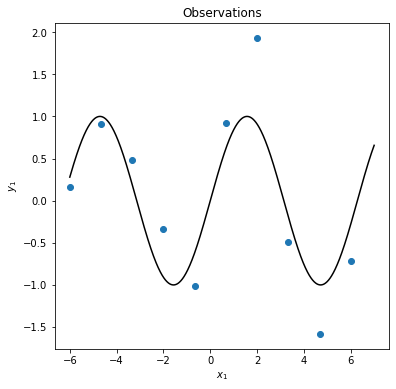

In [258]:
# Plot the observations against the actual underlying function
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(f_x, f_y, c='black')
ax.scatter(x1, y1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$y_1$')
ax.set_title('Observations')
pyplot.show();

Train and Test Model

We now generate a data point for an unknown datapoint outside the bounds of our observations.

In [259]:
# Let's look at a x-value that should return something close to 1
x2 = numpy.array([2 * numpy.pi]).reshape(-1, 1)

In [260]:
# Calculate the variance and covariance matrices required for the conditional moments
Σ11 = kernel(x1, x1)
Σ12 = kernel(x1, x2)
Σ22 = kernel(x2, x2)

In [261]:
Σ12_Σ11 = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T

In [262]:
# Calculate conditional parameters
μ1 = 0
μ2 = 0

μ_2_given_1 = μ2 + Σ12_Σ11 @ (y1 - μ1)
Σ_2_given_1 = Σ22 - (Σ12_Σ11 @ Σ12)

In [263]:
y2 = numpy.random.multivariate_normal(mean=μ_2_given_1.flatten(), cov=Σ_2_given_1, size=5)
y2

array([[-0.32549499],
       [-0.26390864],
       [-0.32222897],
       [ 0.11102714],
       [-0.9738465 ]])

In [265]:
# Compute the standard deviation at the test points to be plotted
σ2 = numpy.sqrt(numpy.diag(Σ_2_given_1))

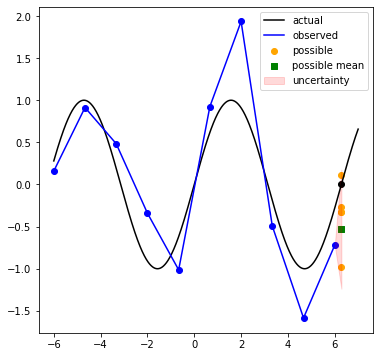

In [324]:
# Plot some samples from this function
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(f_x, f_y, c='black', label='actual')
ax.scatter(x1, y1, c='blue')
ax.plot(x1, y1, c='blue', label='observed')

ax.scatter(numpy.repeat(x2, y2.shape[0]), y2, c='orange', label='possible')
ax.scatter(x2, numpy.sin(x2), c='black')
ax.scatter(x2, μ_2_given_1, c='green', marker='s', label='possible mean')

tmp_x = numpy.array([x1[-1].reshape(-1, 1), x2]).astype('float64').flatten()
tmp_y_lower = numpy.array([y1[-1].reshape(-1, 1), μ_2_given_1 - 3*σ2]).astype('float64').flatten()
tmp_y_top = numpy.array([y1[-1].reshape(-1, 1), μ_2_given_1 + 3*σ2]).astype('float64').flatten()
ax.fill_between(tmp_x, tmp_y_lower, tmp_y_top, color='red', alpha=0.15, label='uncertainty')
ax.legend()
plt.show()


#### 1.6.1.2. Example 2: Non-Zero-Mean Reverting

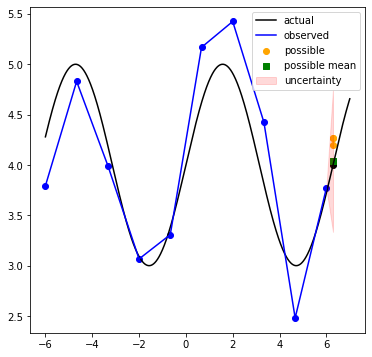

In [333]:
sampe_size = 10
sample_domain = (-6, 6)

# Select evenly spaced datapoints along a number line and place them in a column vector
x1 = numpy.linspace(start=sample_domain[0], stop=sample_domain[1], num=sampe_size)
x1 = numpy.reshape(x1, (-1,1))

# Make observations for each of the selected datapoints
# Define the process as a sine wave with some random noise
e = numpy.random.normal(loc=0, scale=0.4, size=sampe_size).reshape(-1,1)
y1 = numpy.sin(x1) +4 + e

# Generate the actual underlying function without the noise
f_x = numpy.linspace(start=sample_domain[0], stop=sample_domain[1] + 1, num=1000).reshape(-1, 1)
f_y = numpy.sin(f_x) + 4

# Let's look at a x-value that should return something close to 1
x2 = numpy.array([2 * numpy.pi]).reshape(-1, 1)

# Calculate the variance and covariance matrices required for the conditional moments
Σ11 = kernel(x1, x1)
Σ12 = kernel(x1, x2)
Σ22 = kernel(x2, x2)

Σ12_Σ11 = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T

# Calculate conditional parameters
μ1 = 4
μ2 = 4

μ_2_given_1 = μ2 + Σ12_Σ11 @ (y1 - μ1)
Σ_2_given_1 = Σ22 - (Σ12_Σ11 @ Σ12)

y2 = numpy.random.multivariate_normal(mean=μ_2_given_1.flatten(), cov=Σ_2_given_1, size=5)

# Compute the standard deviation at the test points to be plotted
σ2 = numpy.sqrt(numpy.diag(Σ_2_given_1))

# Plot some samples from this function
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(f_x, f_y, c='black', label='actual')
ax.scatter(x1, y1, c='blue')
ax.plot(x1, y1, c='blue', label='observed')

ax.scatter(numpy.repeat(x2, y2.shape[0]), y2, c='orange', label='possible')
ax.scatter(x2, numpy.sin(x2) + 4, c='black')
ax.scatter(x2, μ_2_given_1, c='green', marker='s', label='possible mean')

tmp_x = numpy.array([x1[-1].reshape(-1, 1), x2]).astype('float64').flatten()
tmp_y_lower = numpy.array([y1[-1].reshape(-1, 1), μ_2_given_1 - 3*σ2]).astype('float64').flatten()
tmp_y_top = numpy.array([y1[-1].reshape(-1, 1), μ_2_given_1 + 3*σ2]).astype('float64').flatten()
ax.fill_between(tmp_x, tmp_y_lower, tmp_y_top, color='red', alpha=0.15, label='uncertainty')
ax.legend()
plt.show()

#### 1.6.1.3. Example 3: Non-Stationary

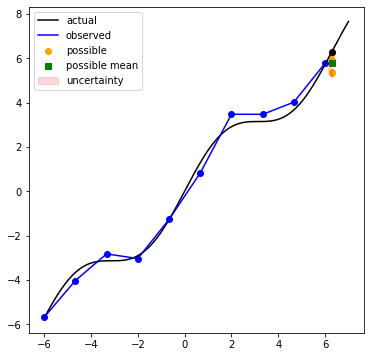

In [347]:
sampe_size = 10
sample_domain = (-6, 6)

# Select evenly spaced datapoints along a number line and place them in a column vector
x1 = numpy.linspace(start=sample_domain[0], stop=sample_domain[1], num=sampe_size).reshape(-1, 1)

# Make observations for each of the selected datapoints
# Define the process as a sine wave with some random noise
e = numpy.random.normal(loc=0, scale=0.4, size=sampe_size).reshape(-1,1)
y1 = numpy.sin(x1) + x1 + e

# Generate the actual underlying function without the noise
f_x = numpy.linspace(start=sample_domain[0], stop=sample_domain[1] + 1, num=1000).reshape(-1, 1)
f_y = numpy.sin(f_x) + f_x

# Let's look at a x-value that should return something close to 1
x2 = numpy.array([2 * numpy.pi]).reshape(-1, 1)

# Calculate the variance and covariance matrices required for the conditional moments
Σ11 = kernel(x1, x1)
Σ12 = kernel(x1, x2)
Σ22 = kernel(x2, x2)

Σ12_Σ11 = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T

# Calculate conditional parameters
μ1 = 4
μ2 = 4

μ_2_given_1 = μ2 + Σ12_Σ11 @ (y1 - μ1)
Σ_2_given_1 = Σ22 - (Σ12_Σ11 @ Σ12)

y2 = numpy.random.multivariate_normal(mean=μ_2_given_1.flatten(), cov=Σ_2_given_1, size=5)

# Compute the standard deviation at the test points to be plotted
σ2 = numpy.sqrt(numpy.diag(Σ_2_given_1))

# Plot some samples from this function
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(f_x, f_y, c='black', label='actual')
ax.scatter(x1, y1, c='blue')
ax.plot(x1, y1, c='blue', label='observed')

ax.scatter(numpy.repeat(x2, y2.shape[0]), y2, c='orange', label='possible')
ax.scatter(x2, numpy.sin(x2) + x2, c='black')
ax.scatter(x2, μ_2_given_1, c='green', marker='s', label='possible mean')

tmp_x = numpy.array([x1[-1].reshape(-1, 1), x2]).astype('float64').flatten()
tmp_y_lower = numpy.array([y1[-1].reshape(-1, 1), μ_2_given_1 - 3*σ2]).astype('float64').flatten()
tmp_y_top = numpy.array([y1[-1].reshape(-1, 1), μ_2_given_1 + 3*σ2]).astype('float64').flatten()
ax.fill_between(tmp_x, tmp_y_lower, tmp_y_top, color='red', alpha=0.15, label='uncertainty')
ax.legend()
plt.show()

### 1.6.2. Interpolation Examples

#### 1.6.2.1. Example 4: Interpolation

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


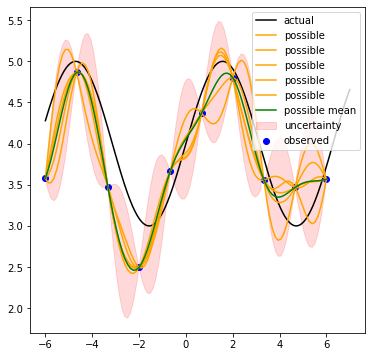

In [400]:
sampe_size = 10
sample_domain = (-6, 6)

# Select evenly spaced datapoints along a number line and place them in a column vector
x1 = numpy.linspace(start=sample_domain[0], stop=sample_domain[1], num=sampe_size)
x1 = numpy.reshape(x1, (-1,1))

# Make observations for each of the selected datapoints
# Define the process as a sine wave with some random noise
e = numpy.random.normal(loc=0, scale=0.4, size=sampe_size).reshape(-1,1)
y1 = numpy.sin(x1) +4 + e

# Generate the actual underlying function without the noise
f_x = numpy.linspace(start=sample_domain[0], stop=sample_domain[1] + 1, num=1000).reshape(-1, 1)
f_y = numpy.sin(f_x) + 4

# Let's look at a x-value that should return something close to 1
x2 = numpy.linspace(stochastic_domain[0], stochastic_domain[1], 100).reshape(-1, 1)

# Calculate the variance and covariance matrices required for the conditional moments
Σ11 = kernel(x1, x1)
Σ12 = kernel(x1, x2)
Σ22 = kernel(x2, x2)

Σ12_Σ11 = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T

# Calculate conditional parameters
μ1 = 4
μ2 = 4

μ_2_given_1 = μ2 + Σ12_Σ11 @ (y1 - μ1)
Σ_2_given_1 = Σ22 - (Σ12_Σ11 @ Σ12)

y2 = numpy.random.multivariate_normal(mean=μ_2_given_1.flatten(), cov=Σ_2_given_1, size=5)

# Compute the standard deviation at the test points to be plotted
σ2 = numpy.sqrt(numpy.diag(Σ_2_given_1)).reshape(-1,1)

# Plot some samples from this function
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(6, 6))

# Plot the actual
ax.plot(f_x, f_y, c='black', label='actual')

# Plot the interpolating processes
for i in range(0, y2.shape[0]):
    ax.plot(x2, y2[i], c='orange', label='possible')

# Plot the predictions
tmp_y_lower = μ_2_given_1 - 3*σ2
tmp_y_top = μ_2_given_1 + 3*σ2
ax.fill_between(x2.flatten(), tmp_y_lower.flatten(), tmp_y_top.flatten(), color='red', alpha=0.15, label='uncertainty')
ax.plot(x2, μ_2_given_1, c='green', label='possible mean')

# Plot the observations
ax.scatter(x1, y1, c='blue', label='observed')

ax.legend()
plt.show()

# 2. References
- https://www.ritchievink.com/blog/2019/02/01/an-intuitive-introduction-to-gaussian-processes/
- http://www.gaussianprocess.org/
- https://brendanhasz.github.io/2018/10/10/hmm-vs-gp.html
- https://distill.pub/2019/visual-exploration-gaussian-processes/
- https://online.stat.psu.edu/stat505/book/export/html/638
- https://peterroelants.github.io/posts/gaussian-process-tutorial/
- https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

- https://arxiv.org/pdf/2009.10862.pdf
- https://www.youtube.com/watch?v=4vGiHC35j9shttps://www.youtube.com/watch?v=4vGiHC35j9s
- https://www.youtube.com/watch?v=exqpaqaPG2Mhttps://www.youtube.com/watch?v=exqpaqaPG2M
- https://maelfabien.github.io/machinelearning/HyperOpt/#gaussian-process-gp